In [1]:
# Mount drive to load celeb_a data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda
from keras.layers import Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras import backend as K
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.initializers import RandomNormal
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from numpy.random import randn
from numpy.random import randint

In [5]:
# load data from saved file
data = np.load('/content/drive/MyDrive/celebA/test1.npy')
data.shape

(10000, 128, 128, 3)

In [6]:
x_train = data

In [7]:
# Shape x_train - Totol # of images: 10000, dim = (128,128,3)
len(x_train), len(x_train[0]), x_train.shape

(10000, 128, (10000, 128, 128, 3))

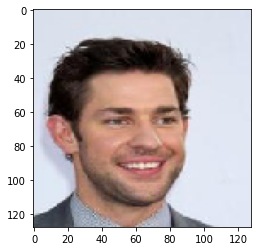

In [8]:
# Preview Image from dataset
plt.imshow((x_train[0]))

In [9]:
#Define input image dimensions
#Large images take too much time and resources. taking dim = (128, 128, 3) 
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)

In [10]:
# Resets all state generated by Keras
K.clear_session()

#initializing weights
weight_init = RandomNormal(mean=0., stddev=0.02)

# Disciminator model 
discriminator_input = Input(shape= img_shape, name='discriminator_input')
x = discriminator_input

# First convolutional layer
x = Conv2D(filters= 64, kernel_size= 5, strides= 2, padding= 'same', name= 'discriminator_conv_1', 
           kernel_initializer= weight_init)(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Dropout(rate = 0.2)(x)

# Second convolutional layer
x = Conv2D(filters= 128, kernel_size= 5, strides= 2, padding= 'same', name= 'discriminator_conv_2', 
           kernel_initializer= weight_init)(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Dropout(rate = 0.2)(x)


# Third convolutional layer
x = Conv2D(filters= 256, kernel_size= 5, strides= 2, padding= 'same', name= 'discriminator_conv_3', 
           kernel_initializer= weight_init)(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Dropout(rate = 0.2)(x)


# Fourth convolutional layer
x = Conv2D(filters= 512, kernel_size= 5, strides= 2, padding= 'same', name= 'discriminator_conv_4', 
           kernel_initializer= weight_init)(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Dropout(rate = 0.2)(x)


x = Flatten()(x)

discriminator_output = Dense(1, activation= 'sigmoid', kernel_initializer= weight_init)(x)

discriminator = Model(discriminator_input, discriminator_output)

In [11]:
# Discriminator model summary
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 128, 128, 3)]     0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
discriminator_conv_2 (Conv2D (None, 32, 32, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0     

In [12]:
# Generator model
generator_input = Input(shape=(100,), name='generator_input')

x = generator_input

x = Dense(np.prod(32768), kernel_initializer= weight_init)(x)
x = BatchNormalization(momentum = 0.9)(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Reshape((8, 8, 512))(x)

x = UpSampling2D()(x)
x = Conv2D(filters= 512, kernel_size= 5, padding= 'same', strides= 1, name = 'generator_conv_1', 
            kernel_initializer= weight_init)(x)
x = BatchNormalization(momentum = 0.9)(x)
x = LeakyReLU(alpha = 0.2)(x)

x = UpSampling2D()(x)
x = Conv2D(filters= 256, kernel_size= 5, padding= 'same', strides= 1, name = 'generator_conv_2', 
            kernel_initializer= weight_init)(x)
x = BatchNormalization(momentum = 0.9)(x)
x = LeakyReLU(alpha = 0.2)(x)

x = UpSampling2D()(x)
x = Conv2D(filters= 64, kernel_size= 5, padding= 'same', strides= 1, name = 'generator_conv_3', 
            kernel_initializer= weight_init)(x)
x = BatchNormalization(momentum = 0.9)(x)
x = LeakyReLU(alpha = 0.2)(x)


x = Conv2DTranspose(filters= 3, kernel_size= 5, padding= 'same', strides= 2, name = 'generator_conv_4',
                    kernel_initializer= weight_init)(x)
x = Activation('sigmoid')(x)

generator_output = x

generator = Model(generator_input, generator_output)

In [13]:
# Generator model summary
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 512)       0         
_________________________________________________________________
generator_conv_1 (Conv2D)    (None, 16, 16, 512)       6554

In [14]:
# freezing weights of generator
generator.trainable = False
for layer in generator.layers:
    layer.trainable = False
    
discriminator.compile(optimizer= RMSprop(lr= 0.0008, decay=6e-8), 
                      loss= 'binary_crossentropy')

# freezing weights of discriminator
discriminator.trainable = False
for layer in discriminator.layers:
    layer.trainable = False
    
# unfreezing weights of generator
generator.trainable = True
for layer in generator.layers:
    layer.trainable = True
    
model_input = Input(shape=(100,), name='model_input')
model_output = discriminator(generator(model_input))

model = Model(model_input, model_output)

model.compile(optimizer= RMSprop(lr=0.0004, decay=3e-8),
              loss= 'binary_crossentropy')

# unfreezing weights of discriminator
discriminator.trainable = True
for layer in discriminator.layers:
    layer.trainable = True

In [15]:
# method to train discriminator
def train_discriminator(x_train, batch_size):

    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))
    
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(x_train, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    return [d_loss, d_loss_real, d_loss_fake]

# method to train generator(
def train_generator(batch_size):
    valid = np.ones((batch_size,1))
    noise = np.random.normal(0, 1, (batch_size, 100))
    return model.train_on_batch(noise, valid)

In [20]:
# Method to save images by generator in drive
def save_imgs(epoch):
    r, c = 6, 6
    noise = np.random.normal(0, 1, (r * c, 100))

    #generate fake image
    gen_imgs = generator.predict(noise)

    fig, axs = plt.subplots(r, c)
    cnt1 = 0
    cnt2 = 0

    #save grey images
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt1, :,:,0],  cmap='gray')
            axs[i,j].axis('off')
            cnt1 += 1
    fig.savefig("/content/drive/MyDrive/celeb_a_predict_img/celeb_a_grey_%d.png" % epoch)
    
    #save color images
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt2, :,:,0])
            axs[i,j].axis('off')
            cnt2 += 1
    fig.savefig("/content/drive/MyDrive/celeb_a_predict_img/celeb_a_color_%d.png" % epoch)
    plt.close()

In [ ]:
import warnings
warnings.filterwarnings("ignore");
epoch = 0

d_losses = []
g_losses = []

data_gen = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32')) / 255)
for e in range(7000):
    print('Epoch', e)
    batches = 0
    for x_batch in data_gen.flow(x_train, batch_size=64):
        batches += 1
        if batches >= len(x_train) / 64:
            break
        d_loss = train_discriminator(x_batch, 64)
        g_loss = train_generator(64)
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    if epoch%20 == 0:
        print ("%d [D loss: (%.3f)(R %.3f, F %.3f)]  [G loss: %.3f] " % (epoch, d_loss[0], d_loss[1], d_loss[2], g_loss))
        save_imgs(e)

Epoch 0
0 [D loss: (0.518)(R 0.664, F 0.373)]  [G loss: 1.558] 
Epoch 1
0 [D loss: (0.079)(R 0.088, F 0.070)]  [G loss: 3.271] 
Epoch 2
0 [D loss: (0.493)(R 0.703, F 0.283)]  [G loss: 2.978] 
Epoch 3
0 [D loss: (0.809)(R 0.515, F 1.104)]  [G loss: 1.993] 
Epoch 4
0 [D loss: (0.618)(R 0.651, F 0.584)]  [G loss: 1.950] 
Epoch 5
0 [D loss: (0.522)(R 0.586, F 0.457)]  [G loss: 2.348] 
Epoch 6
0 [D loss: (0.366)(R 0.574, F 0.158)]  [G loss: 2.323] 
Epoch 7
0 [D loss: (0.336)(R 0.545, F 0.127)]  [G loss: 2.787] 
Epoch 8
0 [D loss: (0.476)(R 0.546, F 0.406)]  [G loss: 5.975] 
Epoch 9
0 [D loss: (0.487)(R 0.837, F 0.137)]  [G loss: 3.826] 
Epoch 10
0 [D loss: (0.025)(R 0.017, F 0.033)]  [G loss: 3.025] 
Epoch 11
0 [D loss: (0.415)(R 0.450, F 0.380)]  [G loss: 4.783] 
Epoch 12
0 [D loss: (0.156)(R 0.176, F 0.136)]  [G loss: 4.143] 
Epoch 13
0 [D loss: (0.190)(R 0.255, F 0.125)]  [G loss: 4.387] 
Epoch 14
0 [D loss: (0.264)(R 0.444, F 0.084)]  [G loss: 3.127] 
Epoch 15
0 [D loss: (0.396)(R 0.625